# NB02: Genomic Organization and Operon Structure

**Project**: Aromatic Catabolism Support Network in ADP1

**Goal**: Map all 51 quinate-specific genes on the ADP1 chromosome, identify operons from intergenic distances, and characterize whether the support genes (Complex I, iron, PQQ) are genomically linked to the pca/qui pathway cluster.

**Inputs**:
- `data/quinate_specific_genes.csv` — 51 quinate-specific genes
- `user_data/berdl_tables.db` — genome_features with gene coordinates

**Outputs**:
- Chromosome map figure
- Operon assignments
- `data/operon_assignments.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sqlite3
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'
DB_PATH = '../user_data/berdl_tables.db'

# Load quinate-specific genes
qs = pd.read_csv(os.path.join(DATA_DIR, 'quinate_specific_genes.csv'))

# Assign categories (same as NB01)
def categorize_gene(row):
    func = str(row['rast_function']) if pd.notna(row['rast_function']) else ''
    if 'NADH' in func and ('ubiquinone' in func or 'oxidoreductase chain' in func):
        return 'Complex I'
    elif any(kw in func.lower() for kw in ['protocatechuate', 'catechol', 'muconate',
             'ketoadipate', 'quinate', 'dehydroquinate']):
        return 'Aromatic pathway'
    elif 'PQQ' in func or 'pyrroloquinoline' in func.lower():
        return 'PQQ biosynthesis'
    elif any(kw in func.lower() for kw in ['siderophore', 'iron', 'exbd', 'tolr',
             'ferrichrome', 'tonb']):
        return 'Iron acquisition'
    elif 'regulator' in func.lower() or 'regulatory' in func.lower():
        return 'Regulation'
    elif 'hypothetical' in func.lower() or 'DUF' in func or 'Uncharacterized' in func:
        return 'Unknown'
    else:
        return 'Other'

qs['category'] = qs.apply(categorize_gene, axis=1)

# Load ALL gene coordinates
conn = sqlite3.connect(DB_PATH)
all_genes = pd.read_sql_query("""
    SELECT feature_id, old_locus_tag, start, end, length, strand, contig_id, rast_function
    FROM genome_features
    ORDER BY start
""", conn)
conn.close()

# How many contigs?
print(f'Total genes: {len(all_genes):,}')
print(f'Contigs: {all_genes["contig_id"].nunique()}')
print(f'Contig sizes (genes):')
print(all_genes['contig_id'].value_counts().to_string())

# Genome length
genome_len = all_genes['end'].max()
print(f'\nGenome length: {genome_len:,} bp')

Total genes: 5,852
Contigs: 4
Contig sizes (genes):
contig_id
NC_005966.1            3235
proteomics_unmapped    2383
unknown                 209
mutant_data              25

Genome length: 3,598,022.0 bp


## 1. Chromosome Map of Quinate-Specific Genes

In [2]:
# Mark quinate-specific genes on the chromosome
qs_positions = all_genes[all_genes['feature_id'].isin(qs['feature_id'])].copy()
qs_positions = qs_positions.merge(qs[['feature_id', 'category', 'specificity_quinate']], on='feature_id')
qs_positions = qs_positions.sort_values('start')

print(f'Quinate-specific genes with coordinates: {len(qs_positions)}')
print()

# Print gene positions by category
print('=== Gene Positions by Category ===')
for cat in ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 'Iron acquisition', 'Regulation', 'Other', 'Unknown']:
    subset = qs_positions[qs_positions['category'] == cat].sort_values('start')
    if len(subset) > 0:
        start_range = f'{subset["start"].min():,}–{subset["start"].max():,}'
        print(f'\n{cat} ({len(subset)} genes, positions {start_range}):')
        for _, row in subset.iterrows():
            locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
            print(f'  {locus:15s} {row["start"]:>9,}–{row["end"]:>9,} {row["strand"]}  '
                  f'{str(row["rast_function"])[:50]}')

Quinate-specific genes with coordinates: 51

=== Gene Positions by Category ===

Aromatic pathway (6 genes, positions 1,711,808.0–1,721,154.0):
  ACIAD1707       1,711,808.0–1,713,164.0 +  3-carboxy-cis,cis-muconate cycloisomerase (EC 5.5.
  ACIAD1708       1,713,160.0–1,713,961.0 +  Beta-ketoadipate enol-lactone hydrolase (EC 3.1.1.
  ACIAD1711       1,715,798.0–1,716,524.0 +  Protocatechuate 3,4-dioxygenase beta chain (EC 1.1
  ACIAD1712       1,716,541.0–1,717,171.0 +  Protocatechuate 3,4-dioxygenase alpha chain (EC 1.
  ACIAD1713       1,717,240.0–1,718,113.0 +  3-dehydroquinate dehydratase I (EC 4.2.1.10)
  ACIAD1716       1,721,154.0–1,723,584.0 +  Quinate/shikimate dehydrogenase [Pyrroloquinoline-

Complex I (10 genes, positions 714,346.0–727,827.0):
  ACIAD0730       714,346.0–714,826.0 +  NADH ubiquinone oxidoreductase chain A (EC 1.6.5.3
  ACIAD0734       717,391.0–717,901.0 +  NADH-ubiquinone oxidoreductase chain E (EC 1.6.5.3
  ACIAD0735       717,897.0–719,229.0 +  NADH-ub

/tmp/ipykernel_10454/2272293003.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


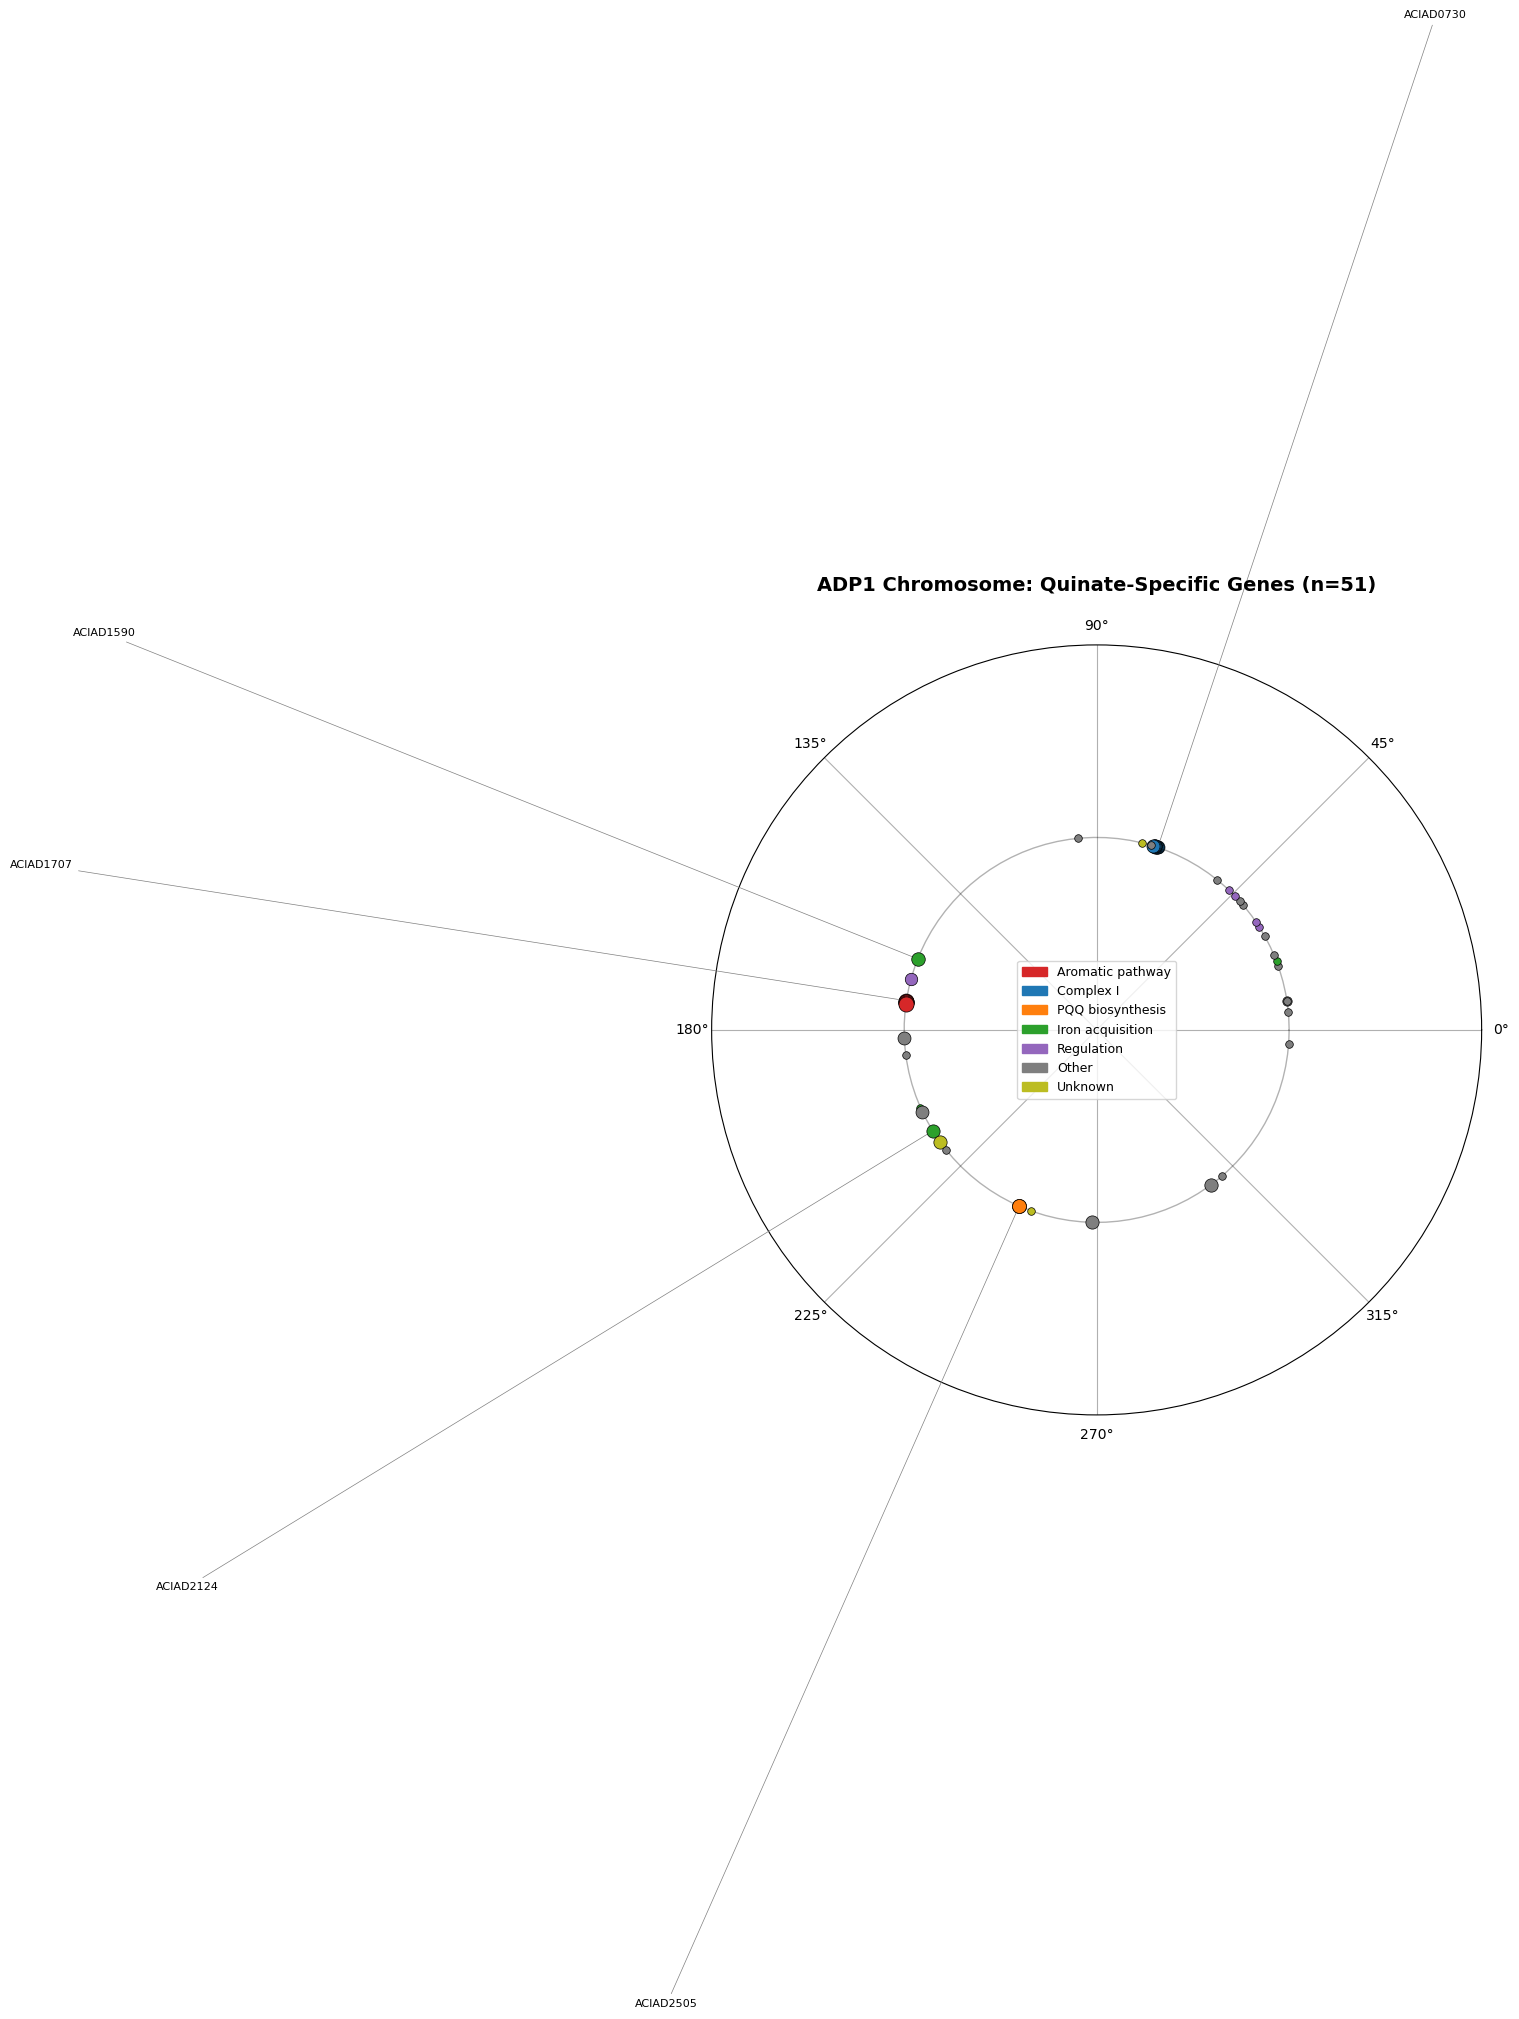

Saved: figures/chromosome_map.png


In [3]:
# Circular chromosome map
cat_colors = {
    'Aromatic pathway': '#d62728',
    'Complex I': '#1f77b4',
    'PQQ biosynthesis': '#ff7f0e',
    'Iron acquisition': '#2ca02c',
    'Regulation': '#9467bd',
    'Other': '#7f7f7f',
    'Unknown': '#bcbd22'
}

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Convert positions to angles (0 to 2π)
for _, row in qs_positions.iterrows():
    angle = 2 * np.pi * row['start'] / genome_len
    color = cat_colors.get(row['category'], 'grey')
    # Size proportional to specificity score
    size = max(30, row['specificity_quinate'] * 15)
    ax.scatter(angle, 1.0, c=color, s=size, zorder=5, edgecolors='black', linewidth=0.5)

# Draw chromosome circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(theta, np.ones_like(theta), 'k-', linewidth=1, alpha=0.3)

# Add gene labels for key clusters
for _, row in qs_positions.iterrows():
    if row['category'] in ['Aromatic pathway', 'Complex I', 'PQQ biosynthesis', 'Iron acquisition']:
        angle = 2 * np.pi * row['start'] / genome_len
        locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else ''
        # Only label first gene in each cluster
        if locus in ['ACIAD1707', 'ACIAD0730', 'ACIAD2505', 'ACIAD1590', 'ACIAD2124']:
            ax.annotate(locus, xy=(angle, 1.0), xytext=(angle, 1.25),
                       fontsize=8, ha='center', arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

ax.set_rticks([])
ax.set_title('ADP1 Chromosome: Quinate-Specific Genes (n=51)', fontsize=14,
             fontweight='bold', pad=20)

# Legend
handles = [mpatches.Patch(color=c, label=l) for l, c in cat_colors.items()]
ax.legend(handles=handles, loc='center', fontsize=9, frameon=True)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'chromosome_map.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/chromosome_map.png')

## 2. Operon Prediction from Intergenic Distances

Two adjacent genes on the same strand with < 100 bp intergenic distance are likely in the same operon.

In [4]:
# Sort all genes by position
all_sorted = all_genes.sort_values(['contig_id', 'start']).reset_index(drop=True)

# Compute intergenic distances between adjacent genes
all_sorted['next_start'] = all_sorted['start'].shift(-1)
all_sorted['next_strand'] = all_sorted['strand'].shift(-1)
all_sorted['next_contig'] = all_sorted['contig_id'].shift(-1)
all_sorted['intergenic'] = all_sorted['next_start'] - all_sorted['end']

# Same strand, same contig, <100 bp gap = same operon
all_sorted['same_operon_as_next'] = (
    (all_sorted['strand'] == all_sorted['next_strand']) &
    (all_sorted['contig_id'] == all_sorted['next_contig']) &
    (all_sorted['intergenic'] < 100) &
    (all_sorted['intergenic'] >= -50)  # allow small overlaps
)

# Assign operon IDs
operon_id = 0
operon_ids = []
for i, row in all_sorted.iterrows():
    operon_ids.append(operon_id)
    if not row['same_operon_as_next']:
        operon_id += 1

all_sorted['operon_id'] = operon_ids

# How many operons contain quinate-specific genes?
qs_operons = all_sorted[all_sorted['feature_id'].isin(qs['feature_id'])].copy()
qs_operons = qs_operons.merge(qs[['feature_id', 'category']], on='feature_id')

print(f'Total operons predicted: {all_sorted["operon_id"].nunique():,}')
print(f'Operons containing quinate-specific genes: {qs_operons["operon_id"].nunique()}')
print(f'Quinate-specific genes in multi-gene operons: '
      f'{qs_operons[qs_operons["operon_id"].map(qs_operons["operon_id"].value_counts()) > 1].shape[0]}')

Total operons predicted: 5,084
Operons containing quinate-specific genes: 35
Quinate-specific genes in multi-gene operons: 20


In [5]:
# Detail the operons containing quinate-specific genes
print('=== Operons Containing Quinate-Specific Genes ===')

# For each operon with >=2 quinate-specific genes, show all genes in the operon
qs_operon_ids = qs_operons['operon_id'].unique()
multi_qs_operons = [oid for oid in qs_operon_ids 
                    if (qs_operons['operon_id'] == oid).sum() >= 2]

print(f'\nOperons with ≥2 quinate-specific genes: {len(multi_qs_operons)}')

for oid in sorted(multi_qs_operons):
    # Get ALL genes in this operon (including non-quinate-specific)
    operon_genes = all_sorted[all_sorted['operon_id'] == oid].sort_values('start')
    qs_in_operon = qs_operons[qs_operons['operon_id'] == oid]
    cats = qs_in_operon['category'].unique()
    
    print(f'\nOperon {oid} ({len(operon_genes)} genes total, {len(qs_in_operon)} quinate-specific, '
          f'categories: {", ".join(cats)}):')
    for _, row in operon_genes.iterrows():
        locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
        func = str(row['rast_function'])[:50] if pd.notna(row['rast_function']) else '?'
        is_qs = '***' if row['feature_id'] in qs['feature_id'].values else '   '
        print(f'  {is_qs} {locus:15s} {row["start"]:>9,}–{row["end"]:>9,} {row["strand"]}  {func}')

=== Operons Containing Quinate-Specific Genes ===

Operons with ≥2 quinate-specific genes: 4

Operon 48 (10 genes total, 2 quinate-specific, categories: Other):
      ACIAD0087        82,938.0– 84,219.0 +  UDP-N-acetyl-D-glucosamine 6-dehydrogenase (EC 1.1
      ACIAD0088        84,248.0– 85,280.0 +  UDP-N-acetylglucosaminuronic acid 4-epimerase (EC 
      ACIAD0089        85,279.0– 86,575.0 +  Peptidoglycan lipid II flippase MurJ
  *** ACIAD0090        86,571.0– 87,672.0 +  Glycosyl transferase, group 1 family protein
  *** ACIAD0091        87,684.0– 88,776.0 +  Glycosyl transferase, group 1
      ACIAD0092        88,772.0– 89,921.0 +  Lipid carrier : UDP-N-acetylgalactosaminyltransfer
      ACIAD0093        89,914.0– 90,529.0 +  Lipid carrier : UDP-N-acetylgalactosaminyltransfer
      ACIAD0094        90,509.0– 91,196.0 +  Acetyltransferase (isoleucine patch superfamily)
      ACIAD0095        91,199.0– 92,375.0 +  4-keto-6-deoxy-N-Acetyl-D-hexosaminyl-(Lipid carri
      ACIAD_RS0045

## 3. Genomic Clustering Analysis

Are the 51 quinate-specific genes more clustered than expected by chance? Do support genes (Complex I, PQQ, iron) co-locate with pathway genes?

In [6]:
# Compute pairwise distances between quinate-specific genes
qs_pos = qs_positions.sort_values('start')
positions = qs_pos['start'].values
categories = qs_pos['category'].values

# Distance to nearest neighbor for each quinate-specific gene
nn_distances = []
for i in range(len(positions)):
    dists = np.abs(positions - positions[i])
    dists[i] = genome_len  # exclude self
    nn_distances.append(dists.min())

qs_pos = qs_pos.copy()
qs_pos['nn_distance'] = nn_distances

# Expected nearest-neighbor distance if 51 genes uniformly distributed
expected_nn = genome_len / (2 * len(qs_pos))  # mean NN distance for uniform
observed_mean_nn = np.mean(nn_distances)

print(f'Nearest-neighbor distances for quinate-specific genes:')
print(f'  Observed mean: {observed_mean_nn:,.0f} bp')
print(f'  Expected (uniform): {expected_nn:,.0f} bp')
print(f'  Ratio (observed/expected): {observed_mean_nn/expected_nn:.2f}')
print(f'  Median NN distance: {np.median(nn_distances):,.0f} bp')
print(f'  Min NN distance: {min(nn_distances):,.0f} bp')
print(f'  Max NN distance: {max(nn_distances):,.0f} bp')

# How many genes are within 10 kb of another quinate-specific gene?
n_clustered = sum(1 for d in nn_distances if d < 10000)
print(f'\nGenes within 10 kb of another quinate-specific gene: {n_clustered} / {len(qs_pos)}')

Nearest-neighbor distances for quinate-specific genes:
  Observed mean: 31,440 bp
  Expected (uniform): 35,275 bp
  Ratio (observed/expected): 0.89
  Median NN distance: 14,163 bp
  Min NN distance: 426 bp
  Max NN distance: 450,150 bp

Genes within 10 kb of another quinate-specific gene: 24 / 51


In [7]:
# Linear chromosome view — zoom in on the pca/qui cluster region
# and the nuo (Complex I) cluster region

# Identify clusters: groups of quinate-specific genes within 20kb
qs_sorted = qs_pos.sort_values('start').reset_index(drop=True)
clusters = []
current_cluster = [0]

for i in range(1, len(qs_sorted)):
    if qs_sorted.loc[i, 'start'] - qs_sorted.loc[current_cluster[-1], 'end'] < 20000:
        current_cluster.append(i)
    else:
        if len(current_cluster) >= 2:
            clusters.append(current_cluster)
        current_cluster = [i]

if len(current_cluster) >= 2:
    clusters.append(current_cluster)

print(f'Genomic clusters of quinate-specific genes (≥2 genes within 20kb): {len(clusters)}')
print()

for ci, cluster in enumerate(clusters):
    genes_in_cluster = qs_sorted.iloc[cluster]
    cats = genes_in_cluster['category'].value_counts()
    span = genes_in_cluster['end'].max() - genes_in_cluster['start'].min()
    
    print(f'Cluster {ci+1}: {len(cluster)} genes, {span:,} bp span')
    print(f'  Categories: {dict(cats)}')
    for _, row in genes_in_cluster.iterrows():
        locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
        print(f'  {locus:15s} [{row["category"]:18s}] {str(row["rast_function"])[:50]}')
    print()

Genomic clusters of quinate-specific genes (≥2 genes within 20kb): 9

Cluster 1: 2 genes, 2,205.0 bp span
  Categories: {'Other': np.int64(2)}
  ACIAD0090       [Other             ] Glycosyl transferase, group 1 family protein
  ACIAD0091       [Other             ] Glycosyl transferase, group 1

Cluster 2: 3 genes, 37,336.0 bp span
  Categories: {'Other': np.int64(2), 'Iron acquisition': np.int64(1)}
  ACIAD0198       [Other             ] ABC transporter, substrate-binding protein (cluste
  ACIAD0214       [Iron acquisition  ] TonB-dependent receptor
  ACIAD0230       [Other             ] UPF0053 inner membrane protein YoaE

Cluster 3: 2 genes, 17,181.0 bp span
  Categories: {'Regulation': np.int64(2)}
  ACIAD0323       [Regulation        ] LysR-family transcriptional regulator YjiE
  ACIAD0347       [Regulation        ] Transcriptional regulator, IclR family

Cluster 4: 2 genes, 15,124.0 bp span
  Categories: {'Other': np.int64(2)}
  ACIAD0403       [Other             ] Magnesium and 

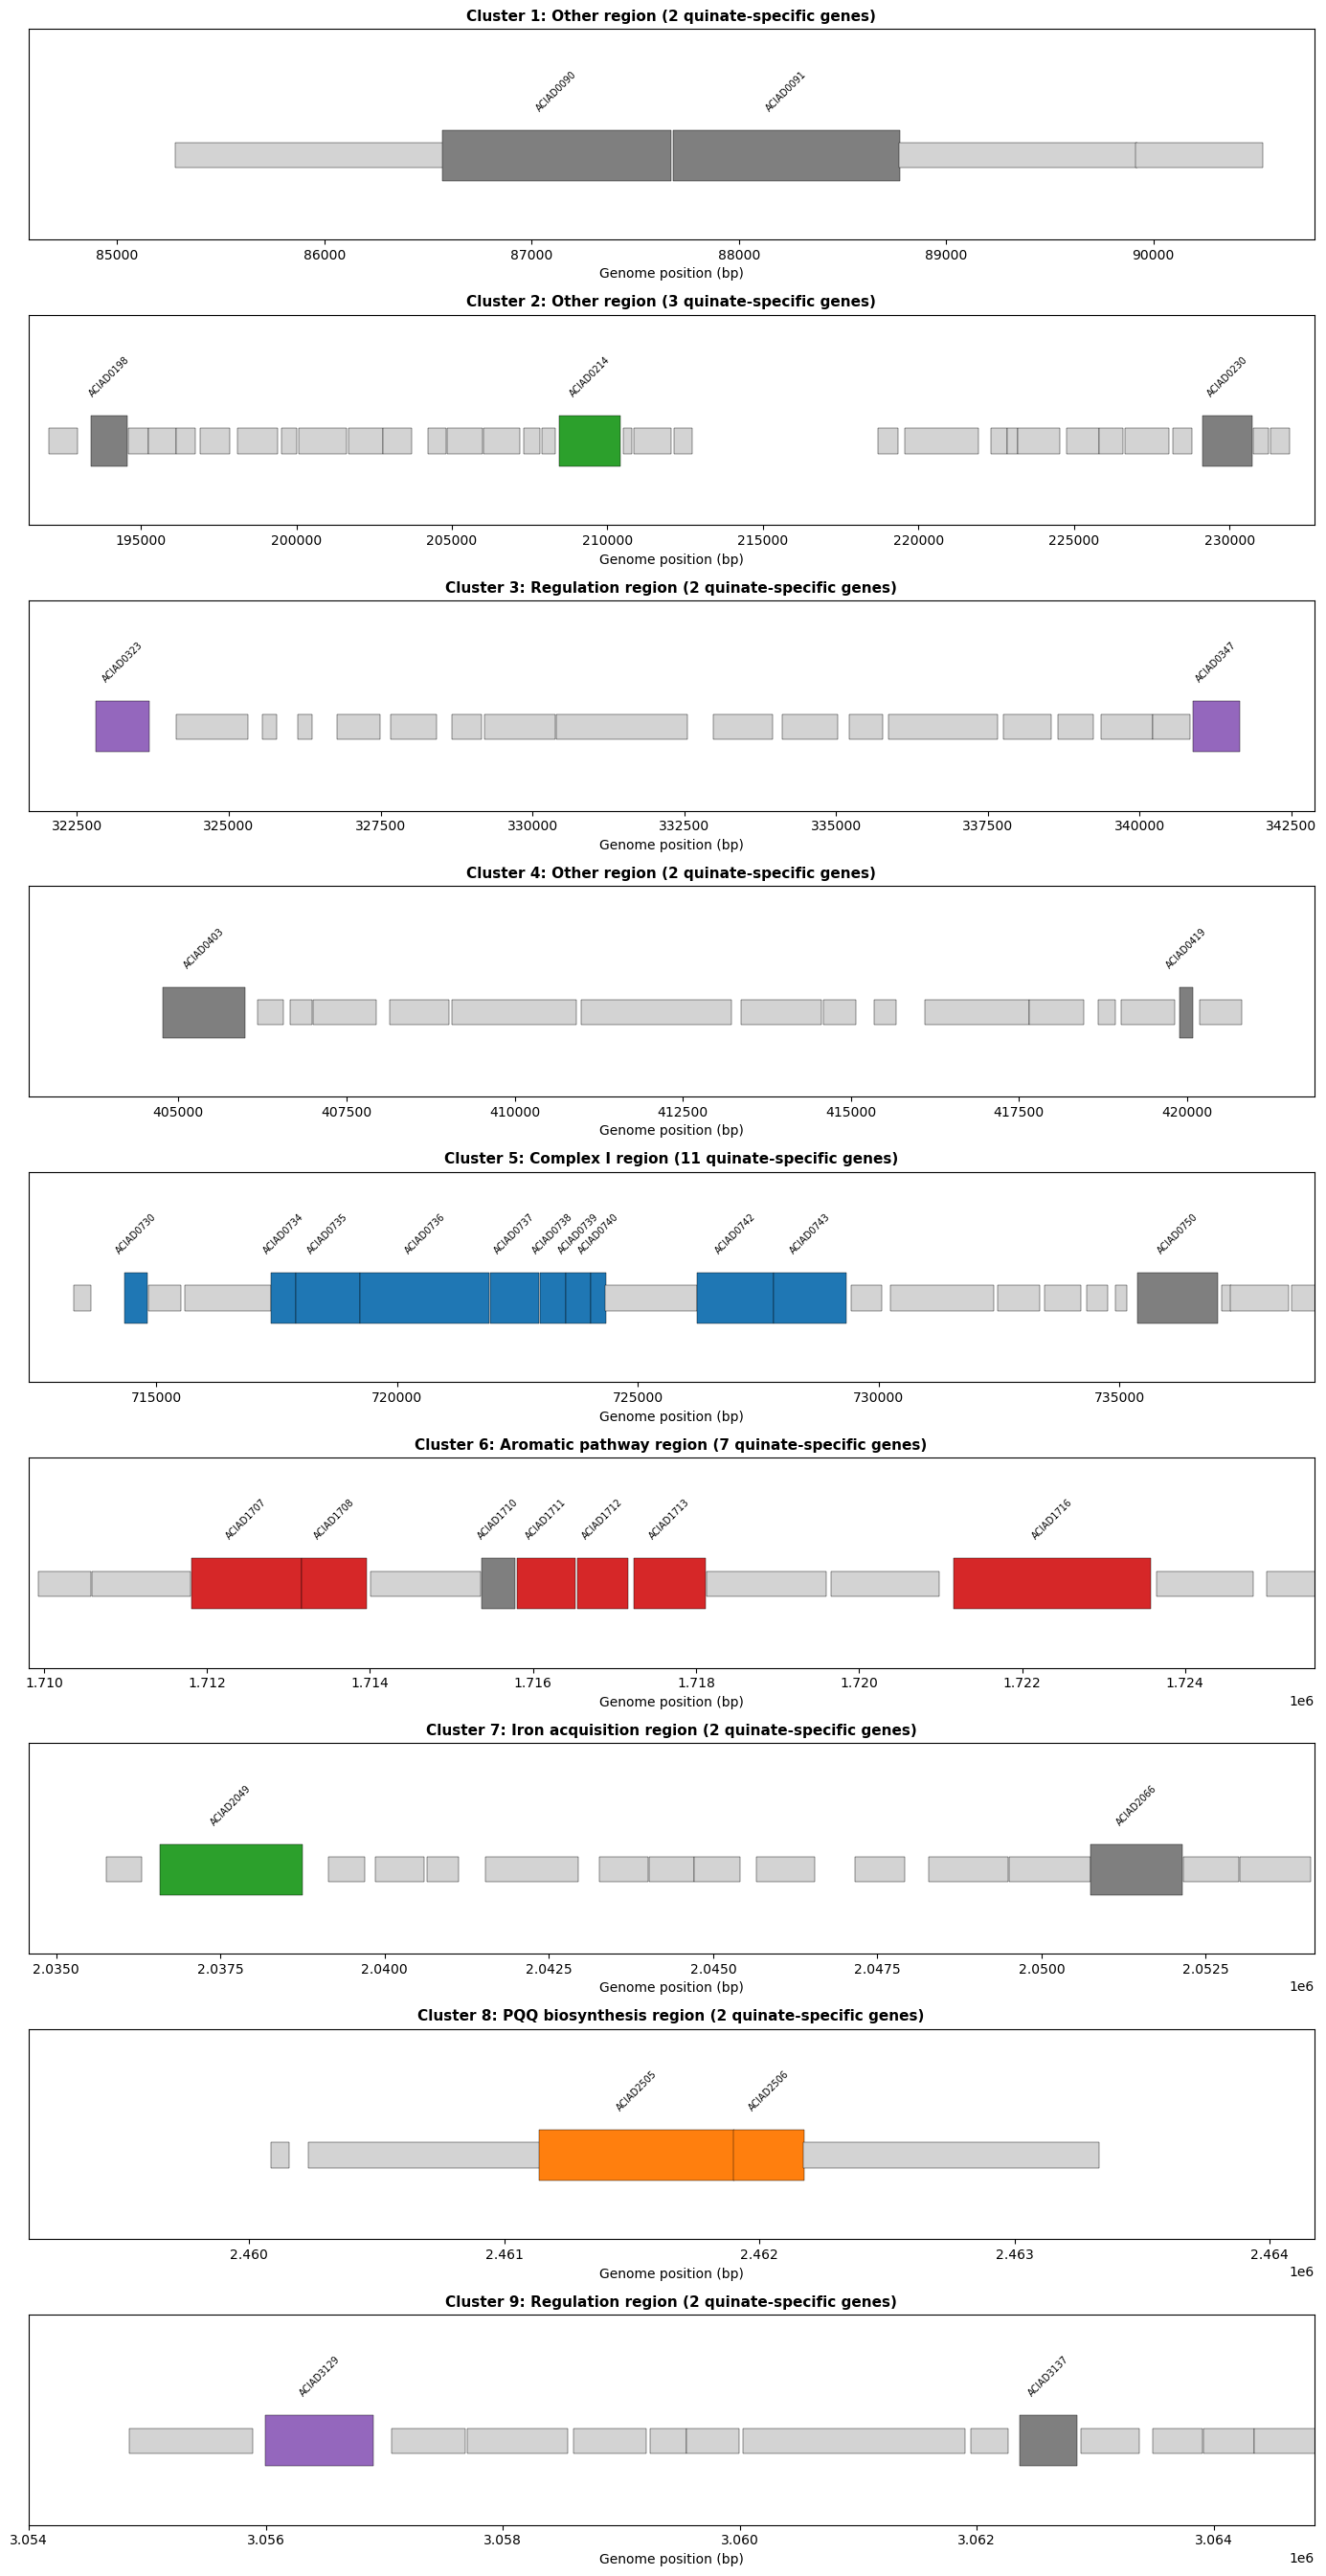

Saved: figures/gene_clusters.png


In [8]:
# Linear view of the major clusters
fig, axes = plt.subplots(len(clusters), 1, figsize=(14, 3 * len(clusters)))
if len(clusters) == 1:
    axes = [axes]

for ci, (cluster, ax) in enumerate(zip(clusters, axes)):
    genes_in_cluster = qs_sorted.iloc[cluster]
    
    # Get ALL genes in this region for context
    region_start = genes_in_cluster['start'].min() - 2000
    region_end = genes_in_cluster['end'].max() + 2000
    region_genes = all_sorted[(all_sorted['start'] >= region_start) & 
                              (all_sorted['end'] <= region_end)].copy()
    
    # Plot all genes in region as grey
    for _, row in region_genes.iterrows():
        color = 'lightgrey'
        height = 0.3
        y_pos = 0
        
        # Color quinate-specific genes by category
        if row['feature_id'] in qs['feature_id'].values:
            cat = qs_pos[qs_pos['feature_id'] == row['feature_id']]['category'].iloc[0]
            color = cat_colors.get(cat, 'grey')
            height = 0.6
        
        direction = 1 if row['strand'] == '+' else -1
        ax.barh(y_pos, row['end'] - row['start'], left=row['start'], 
                height=height, color=color, edgecolor='black', linewidth=0.3)
        
        # Label quinate-specific genes
        if row['feature_id'] in qs['feature_id'].values:
            locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
            gene_mid = (row['start'] + row['end']) / 2
            ax.text(gene_mid, 0.5, locus, fontsize=7, ha='center', va='bottom', rotation=45)
    
    # Get primary category for title
    primary_cat = genes_in_cluster['category'].value_counts().index[0]
    ax.set_title(f'Cluster {ci+1}: {primary_cat} region ({len(genes_in_cluster)} quinate-specific genes)',
                 fontsize=11, fontweight='bold')
    ax.set_xlim(region_start, region_end)
    ax.set_ylim(-1, 1.5)
    ax.set_yticks([])
    ax.set_xlabel('Genome position (bp)')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'gene_clusters.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/gene_clusters.png')

## 4. Cross-Category Operon Sharing

Do any operons contain genes from DIFFERENT support categories? This would indicate physical/regulatory coupling between subsystems.

In [9]:
# Check if any operons span multiple functional categories
print('=== Cross-Category Operons ===')

cross_cat_operons = []
for oid in qs_operons['operon_id'].unique():
    cats_in_operon = qs_operons[qs_operons['operon_id'] == oid]['category'].unique()
    if len(cats_in_operon) >= 2:
        cross_cat_operons.append(oid)
        operon_genes = all_sorted[all_sorted['operon_id'] == oid]
        qs_in = qs_operons[qs_operons['operon_id'] == oid]
        print(f'\nOperon {oid}: categories = {list(cats_in_operon)}')
        for _, row in operon_genes.iterrows():
            locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
            is_qs = '***' if row['feature_id'] in qs['feature_id'].values else '   '
            cat = ''
            if row['feature_id'] in qs_operons['feature_id'].values:
                cat = f' [{qs_operons[qs_operons["feature_id"]==row["feature_id"]]["category"].iloc[0]}]'
            print(f'  {is_qs} {locus:15s}{cat:22s} {str(row["rast_function"])[:45]}')

if len(cross_cat_operons) == 0:
    print('No cross-category operons found.')
    print('Support subsystems (Complex I, PQQ, iron) are in separate operons from the pathway.')

=== Cross-Category Operons ===

Operon 1034: categories = ['Aromatic pathway', 'Other']
      ACIAD_RS07850                         3-oxoadipate CoA-transferase subunit A (EC 2.
      ACIAD_RS07855                         3-oxoadipate CoA-transferase subunit B (EC 2.
      ACIAD_RS07860                         Acetyl-CoA acetyltransferase (EC 2.3.1.9);3-o
  *** ACIAD1707       [Aromatic pathway]    3-carboxy-cis,cis-muconate cycloisomerase (EC
  *** ACIAD1708       [Aromatic pathway]    Beta-ketoadipate enol-lactone hydrolase (EC 3
      ACIAD1709                             4-hydroxybenzoate transporter
  *** ACIAD1710       [Other]               4-carboxymuconolactone decarboxylase (EC 4.1.
  *** ACIAD1711       [Aromatic pathway]    Protocatechuate 3,4-dioxygenase beta chain (E
  *** ACIAD1712       [Aromatic pathway]    Protocatechuate 3,4-dioxygenase alpha chain (
  *** ACIAD1713       [Aromatic pathway]    3-dehydroquinate dehydratase I (EC 4.2.1.10)
      ACIAD1714              

## 5. Save Results

In [10]:
# Save operon assignments for quinate-specific genes
operon_output = qs_operons[['feature_id', 'old_locus_tag', 'start', 'end', 'strand',
                            'category', 'operon_id', 'intergenic', 'same_operon_as_next']].copy()

# Add operon size
operon_sizes = qs_operons['operon_id'].value_counts().to_dict()
operon_output['operon_size'] = operon_output['operon_id'].map(operon_sizes)

operon_output = operon_output.sort_values('start')
operon_output.to_csv(os.path.join(DATA_DIR, 'operon_assignments.csv'), index=False)
print(f'Saved: data/operon_assignments.csv ({len(operon_output)} genes)')

print(f'\n=== NB02 Summary ===')
print(f'Quinate-specific genes mapped: {len(qs_pos)}')
print(f'Genomic clusters (≥2 genes within 20kb): {len(clusters)}')
print(f'Genes in multi-gene operons: {qs_operons[qs_operons["operon_id"].map(qs_operons["operon_id"].value_counts()) > 1].shape[0]}')
print(f'Cross-category operons: {len(cross_cat_operons)}')
print(f'Mean nearest-neighbor distance: {observed_mean_nn:,.0f} bp (expected: {expected_nn:,.0f})')
print(f'Clustering ratio: {observed_mean_nn/expected_nn:.2f} (< 1.0 = more clustered than random)')

Saved: data/operon_assignments.csv (51 genes)

=== NB02 Summary ===
Quinate-specific genes mapped: 51
Genomic clusters (≥2 genes within 20kb): 9
Genes in multi-gene operons: 20
Cross-category operons: 1
Mean nearest-neighbor distance: 31,440 bp (expected: 35,275)
Clustering ratio: 0.89 (< 1.0 = more clustered than random)
